In [1]:
#!/usr/bin/env python3

import pickle as pk
import sys
import time as tm
from argparse import ArgumentParser

import matplotlib.pyplot as plt
import numpy as np
import scipy as sc
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from captum.attr import FeatureAblation
from sklearn.metrics import mean_squared_error, r2_score
from torch.utils.data.dataset import Dataset

sns.set_theme()

batch_size = 50
num_workers = 10

In [2]:
p_latent_space = 200
num_epochs = 1
n_phen = 25

############

n_geno = 100000
n_alleles = 2
latent_space_g = 10000
num_epochs_gen = 1

############

gp_latent_space = p_latent_space
epochs_gen_phen = 1

l1_lambda = 0.00000000000001
l2_lambda = 0.00000000000001

#l1_lambda = 0.08
#l2_lambda = 0.08

In [3]:

class dataset_pheno(Dataset):
    """a class for importing phenotype data.
    It expects a pickled object that is organized as a list of tensors:
    genotypes[n_animals, n_loci, n_alleles] (one hot at allelic state)
    gen_locs[n_animals, n_loci] (index of allelic state)
    weights[n_phens, n_loci, n_alleles] float weight for allelic contribution to phen
    phens[n_animals,n_phens] float value for phenotype
    indexes_of_loci_influencing_phen[n_phens,n_loci_ip] integer indicies of loci that influence a phenotype
    interaction_matrix[FILL THIS IN]
    pleiotropy_matrix[n_phens, n_phens, gen_index]"""

    def __init__(self, data_file, n_phens):
        self.datset = pk.load(open(data_file, "rb"))
        self.phens = torch.tensor(np.array(self.datset["phenotypes"]), dtype=torch.float32)
        self.data_file = data_file
        self.n_phens = n_phens

    def __len__(self):
        return len(self.phens)

    def __getitem__(self, idx):
        phenotypes = self.phens[idx][: self.n_phens]
        return phenotypes

########################################
########################################

class dataset_geno(Dataset):
    """a class for importing simulated genotype-phenotype data.
    It expects a pickled object that is organized as a list of tensors:
    genotypes[n_animals, n_loci, n_alleles] (one hot at allelic state)
    gen_locs[n_animals, n_loci] (index of allelic state)
    weights[n_phens, n_loci, n_alleles] float weight for allelic contribution to phen
    phens[n_animals,n_phens] float value for phenotype
    indexes_of_loci_influencing_phen[n_phens,n_loci_ip] integer indicies of loci that influence a phenotype
    interaction_matrix[FILL THIS IN]
    pleiotropy_matrix[n_phens, n_phens, gen_index]"""

    def __init__(self, data_file, n_geno):
        self.datset = pk.load(open(data_file, "rb"))
        self.genotypes = torch.tensor(np.array(self.datset["genotypes"]), dtype=torch.float32)
        self.data_file = data_file
        self.n_geno = n_geno

    def __len__(self):
        return len(self.genotypes)

    def __getitem__(self, idx):
        genotypes = torch.flatten(self.genotypes[idx])
        return genotypes

#############

class dataset_phen_geno(Dataset):
    """a class for importing simulated genotype-phenotype data.
    It expects a pickled object that is organized as a list of tensors:
    genotypes[n_animals, n_loci, n_alleles] (one hot at allelic state)
    gen_locs[n_animals, n_loci] (index of allelic state)
    weights[n_phens, n_loci, n_alleles] float weight for allelic contribution to phen
    phens[n_animals,n_phens] float value for phenotype
    indexes_of_loci_influencing_phen[n_phens,n_loci_ip] integer indicies of loci that influence a phenotype
    interaction_matrix[FILL THIS IN]
    pleiotropy_matrix[n_phens, n_phens, gen_index]"""

    def __init__(self, data_file, n_geno, n_phens):
        self.datset = pk.load(open(data_file, "rb"))
        self.phens = torch.tensor(np.array(self.datset["phenotypes"]), dtype=torch.float32)
        self.genotypes = torch.tensor(np.array(self.datset["genotypes"]), dtype=torch.float32)
        self.data_file = data_file
        self.n_geno = n_geno
        self.n_phens = n_phens

    def __len__(self):
        return len(self.genotypes)

    def __getitem__(self, idx):
        phenotypes = self.phens[idx][: self.n_phens]
        genotype = torch.flatten(self.genotypes[idx])
        return phenotypes, genotype


In [4]:
train_data_pheno = dataset_pheno('gpatlas/test_sim_WF_1kbt_10000n_5000000bp_test.pk', n_phens=n_phen)
test_data_pheno = dataset_pheno('gpatlas/test_sim_WF_1kbt_10000n_5000000bp_test.pk', n_phens=n_phen)

############

train_data_geno = dataset_geno('gpatlas/test_sim_WF_1kbt_10000n_5000000bp_test.pk', n_geno=n_geno)
test_data_geno = dataset_geno('gpatlas/test_sim_WF_1kbt_10000n_5000000bp_test.pk', n_geno=n_geno)

#############

train_data_phen_geno = dataset_phen_geno('gpatlas/test_sim_WF_1kbt_10000n_5000000bp_test.pk', n_geno=n_geno, n_phens=n_phen)
test_data_phen_geno = dataset_phen_geno('gpatlas/test_sim_WF_1kbt_10000n_5000000bp_test.pk', n_geno=n_geno, n_phens=n_phen)


In [5]:
# setting device on GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)




train_loader_pheno = torch.utils.data.DataLoader(
    dataset=train_data_pheno, batch_size=batch_size, num_workers=num_workers, shuffle=True
)
test_loader_pheno = torch.utils.data.DataLoader(
    dataset=test_data_pheno, batch_size=batch_size, num_workers=num_workers, shuffle=True
)

############


test_loader_geno = torch.utils.data.DataLoader(
    dataset=test_data_geno, batch_size=200, num_workers=1, shuffle=True
)


train_loader_geno = torch.utils.data.DataLoader(
    dataset=train_data_geno, batch_size=200, num_workers=1, shuffle=True
)

#############

train_loader_phen_geno = torch.utils.data.DataLoader(
    dataset=train_data_phen_geno, batch_size=batch_size, num_workers=num_workers, shuffle=True
)
test_loader_phen_geno = torch.utils.data.DataLoader(
    dataset=test_data_phen_geno, batch_size=batch_size, num_workers=num_workers, shuffle=True
)

Using device: cpu


/opt/conda/envs/gpatlas/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [7]:

# encoder
class Q_net(nn.Module):
    def __init__(self, phen_dim=None, N=None):
        super().__init__()
        if N is None:
            N = p_latent_space
        if phen_dim is None:
            phen_dim = n_phen

        batchnorm_momentum = 0.8
        latent_dim = p_latent_space
        self.encoder = nn.Sequential(
            nn.Linear(in_features=phen_dim, out_features=N),
            nn.BatchNorm1d(N, momentum=batchnorm_momentum),
            nn.LeakyReLU(0.01, inplace=True),
            nn.Linear(in_features=N, out_features=latent_dim),
            nn.BatchNorm1d(latent_dim, momentum=batchnorm_momentum),
            nn.LeakyReLU(0.01, inplace=True),
        )

    def forward(self, x):
        x = self.encoder(x)
        return x


# decoder
class P_net(nn.Module):
    def __init__(self, phen_dim=None, N=None):
        if N is None:
            N = p_latent_space
        if phen_dim is None:
            phen_dim = n_phen

        out_phen_dim = n_phen
        #vabs.n_locs * vabs.n_alleles
        latent_dim = p_latent_space

        batchnorm_momentum = 0.8

        super().__init__()
        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_dim, out_features=N),
            nn.BatchNorm1d(N, momentum=batchnorm_momentum),
            nn.LeakyReLU(0.01),
            nn.Linear(in_features=N, out_features=out_phen_dim),
        )

    def forward(self, x):
        x = self.decoder(x)
        return x


In [8]:
# set minimum variable
EPS = 1e-15
reg_lr = 0.001
adam_b = (0.5, 0.999)


# initialize all networks
Q = Q_net()
P = P_net()

Q.to(device)
P.to(device)

optim_P = torch.optim.Adam(P.parameters(), lr=reg_lr, betas=adam_b)
optim_Q_enc = torch.optim.Adam(Q.parameters(), lr=reg_lr, betas=adam_b)

In [9]:

# train phen autoencoder
n_phens = n_phen
n_phens_pred = n_phen
rcon_loss = []

start_time = tm.time()

for n in range(num_epochs):
    for i, (phens) in enumerate(train_loader_pheno):
        phens = phens[:, :n_phens]
        #print(phens)
        phens = phens.to(device)  # move data to GPU if it is there
        batch_size = phens.shape[0]  # redefine batch size here to allow for incomplete batches

        # reconstruction loss
        Q.zero_grad()
        P.zero_grad()

        noise_phens = phens + (0.001**0.5) * torch.randn(phens.shape).to(device)

        z_sample = Q(noise_phens)
        X_sample = P(z_sample)

        # recon_loss = F.mse_loss(X_sample+EPS,phens[:,:n_phens_pred]+EPS)

        recon_loss = F.l1_loss(X_sample + EPS, phens[:, :n_phens_pred] + EPS)

        l1_reg = torch.linalg.norm(torch.sum(Q.encoder[0].weight, axis=0), 1)
        l2_reg = torch.linalg.norm(torch.sum(Q.encoder[0].weight, axis=0), 2)

        recon_loss = recon_loss + l1_reg * 0.0000000001 + l2_reg * 0.000000001


        rcon_loss.append(float(recon_loss.detach()))

        recon_loss.backward()
        optim_Q_enc.step()
        optim_P.step()

    cur_time = tm.time() - start_time
    start_time = tm.time()
    print(
        "Epoch num: "
        + str(n)
        + " batchno "
        + str(i)
        + " r_con_loss: "
        + str(rcon_loss[-1])
        + " epoch duration: "
        + str(cur_time)
    )


/opt/conda/envs/gpatlas/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch num: 0 batchno 29 r_con_loss: 1.4330075979232788 epoch duration: 3.60922908782959


In [10]:
# gencoder
class GQ_net(nn.Module):
    def __init__(self, n_loci=None, N=None):
        super().__init__()
        if N is None:
            N = latent_space_g
        if n_loci is None:
            n_loci = n_geno * n_alleles

        batchnorm_momentum = 0.8
        g_latent_dim = latent_space_g
        self.encoder = nn.Sequential(
            nn.Linear(in_features=n_loci, out_features=N),
            nn.BatchNorm1d(N, momentum=0.8),
            nn.LeakyReLU(0.01),
            nn.Linear(in_features=N, out_features=g_latent_dim),
            nn.BatchNorm1d(g_latent_dim, momentum=0.8),
            nn.LeakyReLU(0.01),
        )

    def forward(self, x):
        x = self.encoder(x)
        return x


# gendecoder
class GP_net(nn.Module):
    def __init__(self, n_loci=None, N=None):
        super().__init__()
        if N is None:
            N = latent_space_g
        if n_loci is None:
            n_loci = n_geno * n_alleles

        batchnorm_momentum = 0.8
        g_latent_dim = latent_space_g
        self.encoder = nn.Sequential(
            nn.Linear(in_features=g_latent_dim, out_features=N),
            nn.BatchNorm1d(N, momentum=batchnorm_momentum),
            nn.LeakyReLU(0.01),
            nn.Linear(in_features=N, out_features=n_loci),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        return x

In [11]:
GQ = GQ_net()
GP = GP_net()

GQ.to(device)
GP.to(device)

EPS = 1e-15
reg_lr = 0.001
adam_b = (0.5, 0.999)

optim_GQ_enc = torch.optim.Adam(GQ.parameters(), lr=reg_lr, betas=adam_b)
optim_GP_dec = torch.optim.Adam(GP.parameters(), lr=reg_lr, betas=adam_b)

In [12]:
g_rcon_loss = []
start_time = tm.time()

gen_noise = 1 - 0.3

for n in range(num_epochs_gen):
    for i, (gens) in enumerate(train_loader_geno):
        batch_size = gens.shape[0]  # redefine batch size here to allow for incomplete batches

        # reconstruction loss
        GP.zero_grad()
        GQ.zero_grad()

        gens = gens[:, : n_geno*n_alleles]

        pos_noise = np.random.binomial(1, gen_noise / 2, gens.shape)

        neg_noise = np.random.binomial(1, gen_noise / 2, gens.shape)

        noise_gens = torch.tensor(
            np.where((gens + pos_noise - neg_noise) > 0, 1, 0), dtype=torch.float32
        )

        noise_gens = noise_gens.to(device)

        gens = gens.to(device)

        z_sample = GQ(noise_gens)
        X_sample = GP(z_sample)



        g_recon_loss = F.binary_cross_entropy(X_sample + EPS, gens + EPS)

        l1_reg = torch.linalg.norm(torch.sum(GQ.encoder[0].weight, axis=0), 1)
        l2_reg = torch.linalg.norm(torch.sum(GQ.encoder[0].weight, axis=0), 2)

        #g_recon_loss = g_recon_loss + l1_reg * 0.00001 + l2_reg * 0.00001
        g_recon_loss = g_recon_loss + l1_reg * 0 + l2_reg * 0

        g_rcon_loss.append(float(g_recon_loss.detach()))

        g_recon_loss.backward()
        optim_GQ_enc.step()
        optim_GP_dec.step()

    cur_time = tm.time() - start_time
    start_time = tm.time()
    print(
        "Epoch num: "
        + str(n)
        + " batchno "
        + str(i)
        + " r_con_loss: "
        + str(g_rcon_loss[-1])
        + " epoch duration: "
        + str(cur_time)
    )

: 

In [ ]:

class GQ_to_P_net(nn.Module):
    def __init__(self, N=None):
        super().__init__()
        if N is None:
            N = gp_latent_space

        batchnorm_momentum = 0.8
        g_latent_dim = latent_space_g
        latent_dim = p_latent_space
        self.encoder = nn.Sequential(
            nn.Linear(in_features=g_latent_dim, out_features=N),
            nn.BatchNorm1d(N, momentum=batchnorm_momentum),
            nn.LeakyReLU(0.01),
            nn.Linear(in_features=N, out_features=latent_dim),
            nn.BatchNorm1d(N, momentum=batchnorm_momentum),
            nn.LeakyReLU(0.01),
        )

    def forward(self, x):
        x = self.encoder(x)
        return x


In [ ]:
GQP = GQ_to_P_net()
GQP.to(device)
optim_GQP_dec = torch.optim.Adam(GQP.parameters(), lr=reg_lr, betas=adam_b)


In [ ]:

# train genotype to phenotype network

P.requires_grad_(False)  # freeze weights in P (phenotype decoder)
P.eval()

GQ.requires_grad_(False)  # freeze weights in GQ (genetic encoder)
GQ.eval()

num_epochs_gen_phen = epochs_gen_phen

gen_noise = 1 - 0.3
#gen_noise = 1 - 0.001


g_p_rcon_loss = []

start_time = tm.time()

for n in range(num_epochs_gen_phen):
    for i, (phens, gens) in enumerate(train_loader_phen_geno):
        phens = phens.to(device)

        gens = gens[:, : n_geno * n_alleles]

        pos_noise = np.random.binomial(1, gen_noise / 2, gens.shape)

        neg_noise = np.random.binomial(1, gen_noise / 2, gens.shape)

        noise_gens = torch.tensor(
            np.where((gens + pos_noise - neg_noise) > 0, 1, 0), dtype=torch.float32
        )

        noise_gens = noise_gens.to(device)

        batch_size = phens.shape[0]

        P.zero_grad()
        GQP.zero_grad()
        GQ.zero_grad()

        z_sample = GQ(noise_gens)
        z_sample = GQP(z_sample)
        X_sample = P(z_sample)

        # g_p_recon_loss = F.mse_loss(X_sample+EPS,phens[:,:n_phens_pred]+EPS)

        g_p_recon_loss = F.l1_loss(X_sample + EPS, phens[:, :n_phens_pred] + EPS)

        g_p_rcon_loss.append(float(g_p_recon_loss.detach()))

        l1_reg = torch.linalg.norm(torch.sum(GQP.encoder[0].weight, axis=0), 1)
        l2_reg = torch.linalg.norm(torch.sum(GQP.encoder[0].weight, axis=0), 2)
        g_p_recon_loss = g_p_recon_loss + l1_reg * l1_lambda + l2_reg * l2_lambda

        g_p_recon_loss.backward()

        optim_P.step()
        optim_GQ_enc.step()
        optim_GQP_dec.step()

    cur_time = tm.time() - start_time
    start_time = tm.time()
    print(
        "Epoch num: "
        + str(n)
        + " batchno "
        + str(i)
        + " r_con_loss: "
        + str(g_p_rcon_loss[-1])
        + " epoch duration: "
        + str(cur_time)
    )


Epoch num: 0 batchno 1699 r_con_loss: 1.948740839958191 epoch duration: 47.66462302207947


In [ ]:
phen_encodings = []
phens = []
phen_latent = []


for dat in test_loader_phen_geno:
    ph, gt = dat
    gt = gt[:, : n_geno * n_alleles]
    ph = ph.to(device)
    gt = gt.to(device)
    batch_size = ph.shape[0]
    z_sample = GQ(gt)
    z_sample = GQP(z_sample)
    X_sample = P(z_sample)
    phens += list(ph.detach().cpu().numpy())
    phen_encodings += list(X_sample.detach().cpu().numpy())
    phen_latent += list(z_sample.detach().cpu().numpy())

phens = np.array(phens).T
phen_encodings = np.array(phen_encodings).T
phen_latent = np.array(phen_latent).T


Text(0, 0.5, 'predicted')

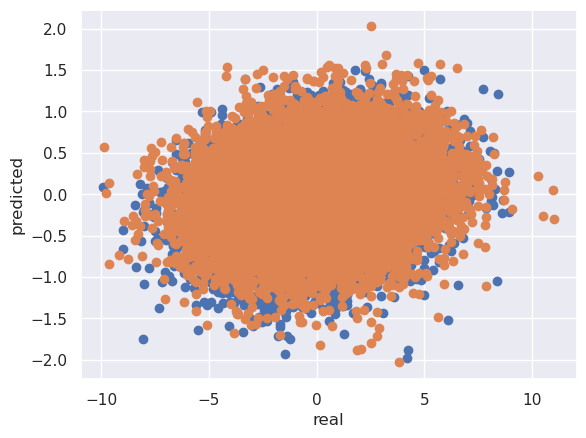

In [ ]:
for n in range(len(phens[:n_phens_pred])):
    plt.plot(phens[n], phen_encodings[n], "o")
plt.xlabel("real")
plt.ylabel("predicted")


[0.2267435533101803, 0.17124754299739245]


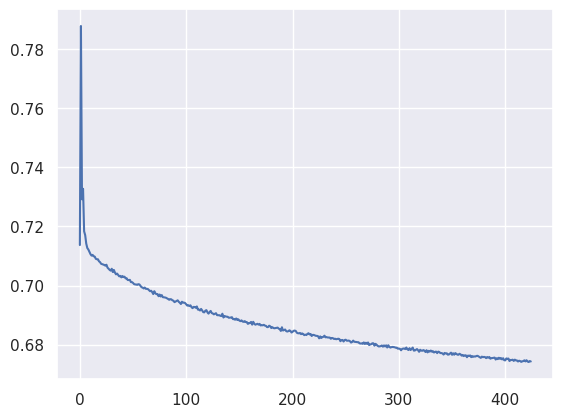

In [ ]:
print([sc.stats.pearsonr(phens[n], phen_encodings[n])[0] for n in range(len(phens[:n_phens_pred]))])

plt.plot(g_rcon_loss)


In [26]:
#device = "cpu"


class GenotypeToPhenotypeNN(nn.Module):
    def __init__(self, input_size = n_geno*n_alleles, latent = p_latent_space):
        super(GenotypeToPhenotypeNN, self).__init__()

        batchnorm_momentum = 0.01
        self.fc = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=3000),
            nn.BatchNorm1d(3000, momentum=batchnorm_momentum),
            nn.LeakyReLU(0.01),

            nn.Linear(in_features=3000, out_features=500),
            nn.BatchNorm1d(500, momentum=batchnorm_momentum),
            nn.LeakyReLU(0.01),

            nn.Linear(in_features=500, out_features=200),
            nn.BatchNorm1d(200, momentum=batchnorm_momentum),
            nn.LeakyReLU(0.01),

            nn.Linear(in_features=200, out_features=25),
        )


    def forward(self, x):
        x = self.fc(x)  # Fully connected layer
        return x



GQP_FC = GenotypeToPhenotypeNN()
GQP_FC.to(device)
optim_GQP_FC_dec = torch.optim.Adam(GQP_FC.parameters(), lr=reg_lr, betas=adam_b)


In [31]:
num_epochs_gen_phen = 5
g_p_rcon_loss = []
start_time = tm.time()

#P.requires_grad_(False)  # freeze weights in P (phenotype decoder)
#P.eval()

for n in range(num_epochs_gen_phen):
    for i, (phens, gens) in enumerate(train_loader_phen_geno):

        phens = phens.to(device)
        gens = gens[:, : n_geno * n_alleles]
        gens = gens.to(device)
        batch_size = phens.shape[0]

        optim_GQP_FC_dec.zero_grad()


        #P.zero_grad()
        GQP_FC.zero_grad()

        #z_sample = GQP_FC(gens)
        #X_sample = P(z_sample)
        X_sample = GQP_FC(gens)

        g_p_recon_loss = F.l1_loss(X_sample + EPS, phens[:, :n_phens_pred] + EPS)
        g_p_rcon_loss.append(float(g_p_recon_loss.detach()))
        g_p_recon_loss.backward()
        optim_GQP_FC_dec.step()
        optim_P.step()

    cur_time = tm.time() - start_time
    start_time = tm.time()
    print(
        "Epoch num: "
        + str(n)
        + " batchno "
        + str(i)
        + " r_con_loss: "
        + str(g_p_rcon_loss[-1])
        + " epoch duration: "
        + str(cur_time)
    )

Epoch num: 0 batchno 29 r_con_loss: 1.1682273149490356 epoch duration: 31.79931926727295
Epoch num: 1 batchno 29 r_con_loss: 1.125962495803833 epoch duration: 31.879092931747437
Epoch num: 2 batchno 29 r_con_loss: 0.99664306640625 epoch duration: 31.915528059005737
Epoch num: 3 batchno 29 r_con_loss: 0.952307403087616 epoch duration: 31.864851236343384
Epoch num: 4 batchno 29 r_con_loss: 0.8624827265739441 epoch duration: 31.7665855884552


[0.8944667021357997, 0.896518427091129, 0.8914208404990656, 0.9022857211890392, 0.8909599382451479, 0.8996458805842593, 0.8898988121744367, 0.8900254135141381, 0.8822462820463031, 0.9037476735506758, 0.892584490674011, 0.9080619124967333, 0.8988172383554698, 0.8887602028363131, 0.8983177144441505, 0.9017858454082202, 0.8834027852880517, 0.8939272187501359, 0.9022069170942686, 0.8926467007905714, 0.9047968266714461, 0.9055936721014302, 0.8931748620524249, 0.8981213750877899, 0.8991448942996434]


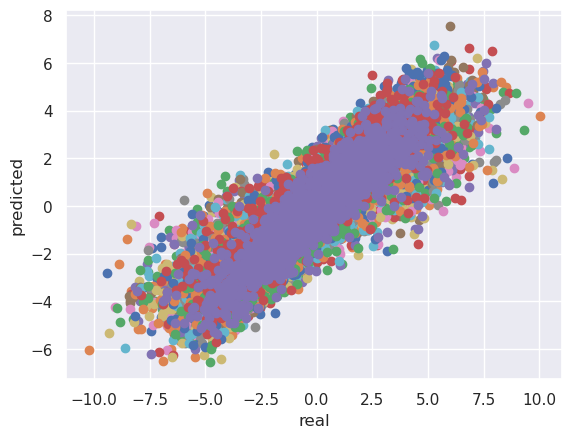

In [32]:
phen_encodings = []
phens = []
phen_latent = []


for dat in test_loader_phen_geno:
    ph, gt = dat
    gt = gt[:, : n_geno * n_alleles]
    ph = ph.to(device)
    gt = gt.to(device)
    batch_size = ph.shape[0]
    #z_sample = GQP_FC(gt)
    #X_sample = P(z_sample)
    X_sample = GQP_FC(gt)

    phens += list(ph.detach().cpu().numpy())
    phen_encodings += list(X_sample.detach().cpu().numpy())
    phen_latent += list(z_sample.detach().cpu().numpy())

phens = np.array(phens).T
phen_encodings = np.array(phen_encodings).T
phen_latent = np.array(phen_latent).T


for n in range(len(phens[:n_phens_pred])):
    plt.plot(phens[n], phen_encodings[n], "o")
plt.xlabel("real")
plt.ylabel("predicted")

print([sc.stats.pearsonr(phens[n], phen_encodings[n])[0] for n in range(len(phens[:n_phens_pred]))])